In [74]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# imports for time series analysis
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# imports for time series forecasting
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import *
from sktime.forecasting.naive import NaiveForecaster

# call ARIMA (includes sarima/sarimax) model
from statsmodels.tsa.arima.model import ARIMA

## another SARIMAX implementation from statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX

import warnings
warnings.filterwarnings("ignore")

# load inflow dataset into dataframe
#inflow_data = pd.read_excel("../InflowData_1.xlsx")
inflow_data = pd.read_csv("../data/inflow_data_imputed.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
#inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")
inflow_data.index = pd.to_datetime(inflow_data.index)

# # print first two rows
# inflow_data.head(3)

In [75]:
# weather data
weather_data = pd.read_csv("../data/weather_data_imputed.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index)

In [76]:
# make list of special days for the DMAs region
official_holidays = ["2021-01-01","2021-01-06","2021-04-04","2021-04-05","2021-04-25","2021-05-01","2021-06-02","2021-08-15","2021-11-01","2021-12-05","2021-12-25","2021-12-26","2022-01-01","2022-01-06","2022-04-17","2022-04-18","2022-04-25","2022-05-01","2022-06-22","2022-08-15","2022-11-01","2022-12-08","2022-12-25","2022-12-26"]

legally_not_recongnized_holidays = ["2021-04-23","2021-05-23","2022-04-23","2022-06-05"]

event_day = ["2021-03-28","2021-05-09","2021-10-31","2021-11-28","2021-05-12","2021-12-12","2021-12-19","2021-12-31","2022-03-27","2022-04-10","2022-05-08","2022-05-09","2022-10-30","2022-11-27","2022-12-04","2022-12-11","2022-12-18","2022-12-31"]

# make columns for special days
weather_data['official_holiday'] = 0
weather_data['legally_not_recongnized_holidays'] = 0
weather_data['event_day'] = 0
weather_data['weekend'] = 0

# add indicator variable for speciall days
for i in weather_data.index:
    if str(i)[:10] in official_holidays:
        weather_data['official_holiday'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in legally_not_recongnized_holidays:
        weather_data['legally_not_recongnized_holidays'][i] = 1

for i in weather_data.index:
    if str(i)[:10] in event_day:
        weather_data['event_day'][i] = 0

# add variable for weekend days
for i in weather_data.index:
    if i.weekday() == 5 or i.weekday() == 6:
        weather_data['weekend'][i] = 1

In [77]:
# create an utility metric function
def print_metrics(y_obs,y_pred, model_name,return_df=None):
    MeanAE_24h = 1/24 * np.sum(np.abs(y_obs[0:24] - y_pred[0:24]))

    MaxAE_24h = np.max(np.abs(y_obs[0:24] - y_pred[0:24]))

    MeanAE_144h = 1/144 * np.sum(np.abs(y_obs[24:168] - y_pred[24:168]))

    total_sum = np.sum(MeanAE_24h + MaxAE_24h + MeanAE_144h)

    dict_ = {'MeanAE-24h': MeanAE_24h, 'MaxAE-24h': MaxAE_24h,
             'MeanAE-144h': MeanAE_144h, 'Total': total_sum}
    
    df = pd.DataFrame(dict_, index = [model_name])
    
    print(model_name)
    print(f"MeanAE-24h      MaxAE-24h      MeanAE-144h      Total")
    print(f"{MeanAE_24h:.2f}            {MaxAE_24h:.2f}             {MeanAE_144h:.2f}           {total_sum:.2f} \n")
    if return_df == 1:
        return(df.round(decimals = 3))

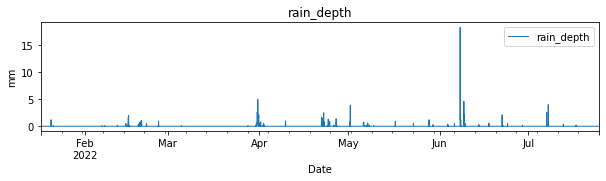

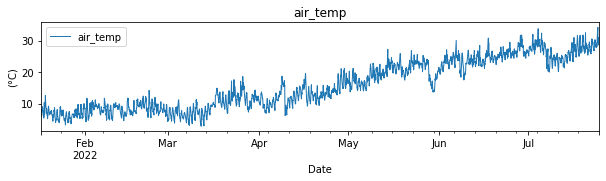

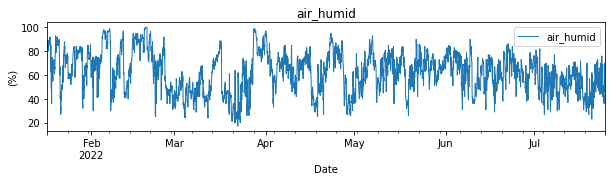

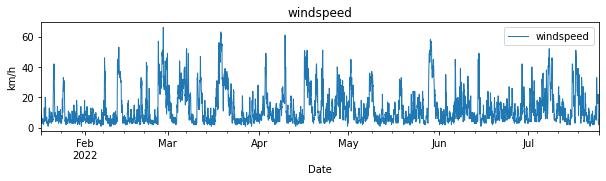

In [86]:
# define start and end dates for analysis (last week is used for evaluation)
start = '2022-01-17'
end = '2022-07-24'

# make feature time series dataframe
tseriesX_df = weather_data.copy()

## add weekened and holidays as exogenous variable (one hot encoded)
# tseriesX_df['weekend (0/1)'] = 0
# tseriesX_df[0:24] = 1
# tseriesX_df[144:192] = 1
# tseriesX_df[312:360] = 1

# reduce time series to specified start and end dates
tseriesX_df = tseriesX_df[start:end].copy()

# make train and test sets
X = tseriesX_df
X_train, X_test = temporal_train_test_split(X, test_size=168)

# fill missing values with interpolation technique
#tseriesX_df.interpolate(limit_direction='both',inplace=True)

## visualize weather data

# RAINFALL
var = 'rain_depth'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("mm")
plt.legend()
plt.show()

# AIR TEMPERATURE
var = 'air_temp'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(°C)")
plt.legend()
plt.show()

# AIR HUMIDITY
var = 'air_humid'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("(%)")
plt.legend()
plt.show()

# WINDSPEED
var = 'windspeed'
fig, ax = plt.subplots(figsize = (10,2))
tseriesX_df.plot(y=var,use_index=True,ax = ax, linewidth=1,label=var)
#weather_data[start:end].plot(y=var,use_index=True,ax = ax, linewidth=1, label='Original')
plt.title(var)
plt.xlabel("Date")
plt.ylabel("km/h")
plt.legend()
plt.show()

In [91]:
import numpy as np
import pandas as pd
import pmdarima as pm
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import ParameterGrid

In [93]:
#Grid
from sklearn.model_selection import ParameterGrid
param_grid = {'p': [0,1],
              'd': [0,1],
              'q': [0,1],
              'P': [0,1],
              'D': [0,1],
              'Q': [0,1]}
grid = ParameterGrid(param_grid)

#printing how many combinations are to be tested. Especially with 6 different parameters, the combinations grow exponentially which influence how long it takes.
len(list(grid))


64

In [ ]:
#Parameter tuning -> start by creating an empty list to store the errors
rmse = []
#Parameter loop
for params in grid:
  #model
  model = pm.ARIMA(order = (params['p'],params['d'],params['q']),
                  seasonal_order = (params['P'],params['D'],params['Q'], 7),
                  X = X,
                  suppress_warning = True,
                  force_stationarity = False)
  #CV
  cv = model_selection.RollingForecastCV(h = 6,
                                        step = 1,
                                        initial = data.shape[0] - 24)
  cv_score = model_selection.cross_val_score(model,
                                            y = data,
                                            scoring = 'mean_squared_error',
                                            cv = cv,
                                            verbose = 2,
                                            error_score = 1000000000000000)

  #Error
  error = np.sqrt(np.average(cv_score))
  rmse.append(error)

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.96587D+00    |proj g|=  1.43261D-01


 This problem is unconstrained.



At iterate    5    f=  1.91144D+00    |proj g|=  7.02542D-02

At iterate   10    f=  1.88963D+00    |proj g|=  2.15552D-02

At iterate   15    f=  1.88343D+00    |proj g|=  2.22859D-02

At iterate   20    f=  1.88295D+00    |proj g|=  2.91342D-03

At iterate   25    f=  1.88278D+00    |proj g|=  1.13571D-02

At iterate   30    f=  1.88276D+00    |proj g|=  5.56528D-03

At iterate   35    f=  1.88265D+00    |proj g|=  4.95624D-03

At iterate   40    f=  1.88253D+00    |proj g|=  7.98276D-03

At iterate   45    f=  1.88252D+00    |proj g|=  1.14249D-03

At iterate   50    f=  1.88251D+00    |proj g|=  1.37032D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

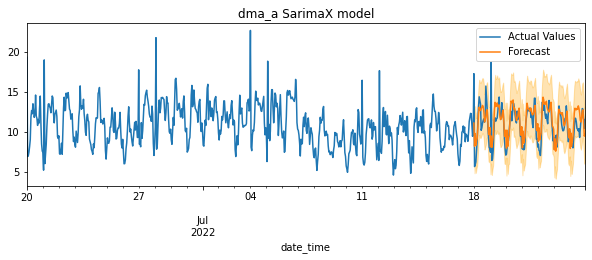

Performance indicators
dma_a SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.66            6.22             1.06           8.95 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.40            6.55             1.72           10.67 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03597D+00    |proj g|=  4.50462D-01


 This problem is unconstrained.



At iterate    5    f=  1.00069D+00    |proj g|=  8.11788D-02

At iterate   10    f=  9.72488D-01    |proj g|=  7.01183D-01

At iterate   15    f=  9.59689D-01    |proj g|=  1.25286D-01

At iterate   20    f=  9.59156D-01    |proj g|=  9.80671D-02

At iterate   25    f=  9.56951D-01    |proj g|=  6.38108D-02

At iterate   30    f=  9.54042D-01    |proj g|=  5.75353D-02

At iterate   35    f=  9.53722D-01    |proj g|=  3.19289D-02

At iterate   40    f=  9.53419D-01    |proj g|=  3.46231D-02

At iterate   45    f=  9.53381D-01    |proj g|=  1.48367D-02

At iterate   50    f=  9.53285D-01    |proj g|=  8.35763D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

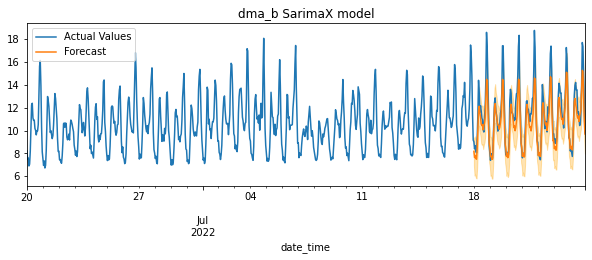

Performance indicators
dma_b SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.14            4.11             0.84           6.09 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.22            8.16             2.25           12.63 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.61643D-01    |proj g|=  1.11746D+00

At iterate    5    f=  8.14673D-01    |proj g|=  3.31843D-01

At iterate   10    f=  7.98189D-01    |proj g|=  7.00250D-01

At iterate   15    f=  7.85073D-01    |proj g|=  3.83176D-01

At iterate   20    f=  7.75511D-01    |proj g|=  4.11098D-02

At iterate   25    f=  7.73542D-01    |proj g|=  1.53800D-01

At iterate   30    f=  7.70785D-01    |proj g|=  1.34197D-01

At iterate   35    f=  7.69414D-01    |proj g|=  1.87513D-02

At iterate   40    f=  7.69251D-01    |proj g|=  8.01597D-03

At iterate   45    f=  7.69226D-01    |proj g|=  5.70647D-03

At iterate   50    f=  7.69138D-01    |proj g|=  3.12441D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

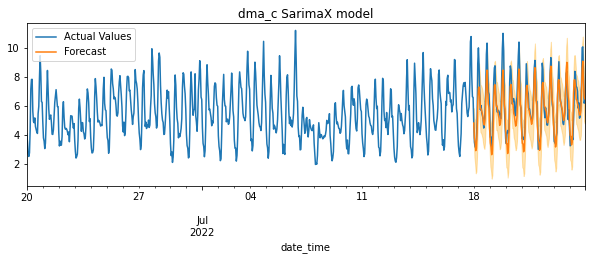

Performance indicators
dma_c SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.76            2.77             0.61           4.14 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.75            4.92             1.52           8.20 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.42491D+00    |proj g|=  9.16949D-02


 This problem is unconstrained.



At iterate    5    f=  2.35729D+00    |proj g|=  3.10764D-01

At iterate   10    f=  2.33521D+00    |proj g|=  2.84745D-02

At iterate   15    f=  2.32474D+00    |proj g|=  1.19615D-02

At iterate   20    f=  2.32377D+00    |proj g|=  1.75186D-02

At iterate   25    f=  2.32363D+00    |proj g|=  8.44418D-03

At iterate   30    f=  2.32358D+00    |proj g|=  1.72508D-03

At iterate   35    f=  2.32353D+00    |proj g|=  3.92476D-03

At iterate   40    f=  2.32346D+00    |proj g|=  4.70663D-03

At iterate   45    f=  2.32343D+00    |proj g|=  5.83317D-04

At iterate   50    f=  2.32341D+00    |proj g|=  2.78907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

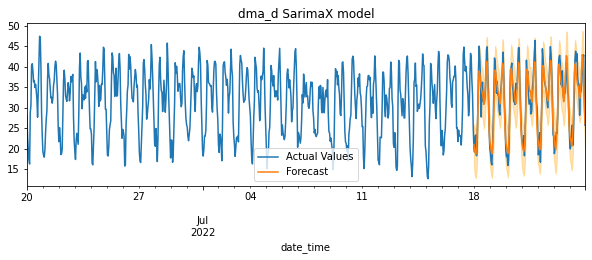

Performance indicators
dma_d SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.35            7.17             2.25           11.77 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
6.79            13.67             6.69           27.15 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.30796D+00    |proj g|=  2.47330D-01


 This problem is unconstrained.



At iterate    5    f=  2.25466D+00    |proj g|=  1.38001D-01

At iterate   10    f=  2.24578D+00    |proj g|=  8.38923D-02

At iterate   15    f=  2.24275D+00    |proj g|=  8.52435D-03

At iterate   20    f=  2.24148D+00    |proj g|=  3.46004D-02

At iterate   25    f=  2.24087D+00    |proj g|=  5.89737D-03

At iterate   30    f=  2.24062D+00    |proj g|=  1.62285D-02

At iterate   35    f=  2.24001D+00    |proj g|=  2.10509D-02

At iterate   40    f=  2.23892D+00    |proj g|=  5.72907D-03

At iterate   45    f=  2.23879D+00    |proj g|=  2.34800D-03

At iterate   50    f=  2.23854D+00    |proj g|=  1.79999D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

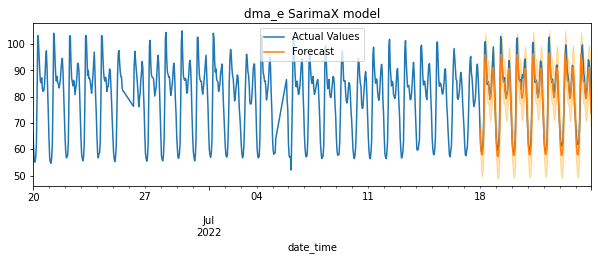

Performance indicators
dma_e SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
2.28            8.86             2.56           13.69 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
10.89            21.46             10.60           42.95 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.60581D+00    |proj g|=  2.31787D-01

At iterate    5    f=  1.55379D+00    |proj g|=  7.52725D-02

At iterate   10    f=  1.53103D+00    |proj g|=  9.82283D-02

At iterate   15    f=  1.52096D+00    |proj g|=  1.87762D-02

At iterate   20    f=  1.52062D+00    |proj g|=  6.56273D-03

At iterate   25    f=  1.52010D+00    |proj g|=  2.80497D-02

At iterate   30    f=  1.52003D+00    |proj g|=  4.20489D-03

At iterate   35    f=  1.51990D+00    |proj g|=  7.82336D-03

At iterate   40    f=  1.51979D+00    |proj g|=  1.46111D-02

At iterate   45    f=  1.51978D+00    |proj g|=  2.67233D-03

At iterate   50    f=  1.51971D+00    |proj g|=  1.00189D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

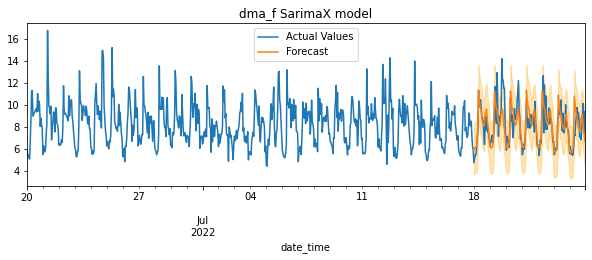

Performance indicators
dma_f SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.63            2.11             0.92           3.66 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.45            3.47             1.37           6.29 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.70506D+00    |proj g|=  1.56860D-01

At iterate    5    f=  1.66609D+00    |proj g|=  1.52571D-01

At iterate   10    f=  1.63215D+00    |proj g|=  1.04282D-02

At iterate   15    f=  1.63094D+00    |proj g|=  1.09859D-02

At iterate   20    f=  1.63056D+00    |proj g|=  1.97869D-02

At iterate   25    f=  1.63027D+00    |proj g|=  5.63936D-03

At iterate   30    f=  1.62988D+00    |proj g|=  6.67296D-03

At iterate   35    f=  1.62986D+00    |proj g|=  3.76946D-03

At iterate   40    f=  1.62984D+00    |proj g|=  1.71257D-02

At iterate   45    f=  1.62979D+00    |proj g|=  1.00771D-02

At iterate   50    f=  1.62974D+00    |proj g|=  1.80643D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

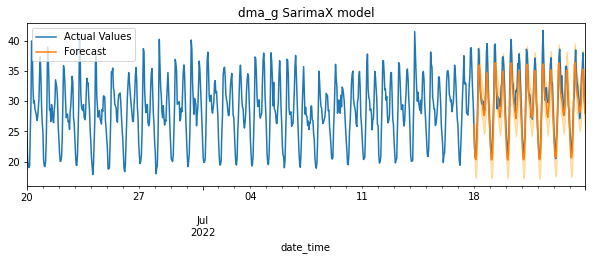

Performance indicators
dma_g SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.39            4.83             1.62           7.83 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.27            11.09             4.61           19.98 



 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.32674D+00    |proj g|=  2.15147D-01

At iterate    5    f=  1.25826D+00    |proj g|=  1.42221D-01

At iterate   10    f=  1.24488D+00    |proj g|=  1.69336D-02

At iterate   15    f=  1.24431D+00    |proj g|=  4.69837D-02

At iterate   20    f=  1.24376D+00    |proj g|=  8.09919D-03

At iterate   25    f=  1.24355D+00    |proj g|=  6.03444D-03

At iterate   30    f=  1.24338D+00    |proj g|=  1.04835D-02

At iterate   35    f=  1.24330D+00    |proj g|=  3.15902D-03

At iterate   40    f=  1.24330D+00    |proj g|=  3.37576D-04

At iterate   45    f=  1.24329D+00    |proj g|=  1.55845D-03

At iterate   50    f=  1.24328D+00    |proj g|=  2.22555D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

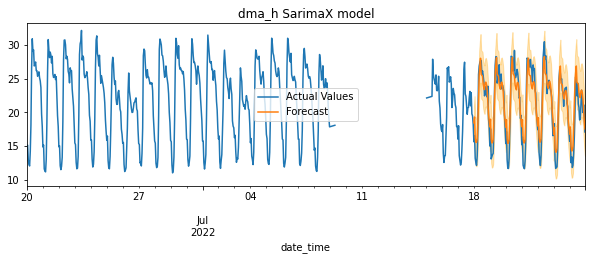

Performance indicators
dma_h SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.63            3.86             1.58           7.07 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.46            9.51             4.49           18.46 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.84125D+00    |proj g|=  1.96033D-01


 This problem is unconstrained.



At iterate    5    f=  1.77028D+00    |proj g|=  2.47180D-01

At iterate   10    f=  1.74817D+00    |proj g|=  1.07267D-01

At iterate   15    f=  1.73557D+00    |proj g|=  5.03283D-02

At iterate   20    f=  1.73283D+00    |proj g|=  1.89055D-02

At iterate   25    f=  1.73222D+00    |proj g|=  2.26531D-02

At iterate   30    f=  1.73201D+00    |proj g|=  5.76467D-03

At iterate   35    f=  1.73195D+00    |proj g|=  3.32882D-03

At iterate   40    f=  1.73190D+00    |proj g|=  1.09199D-02

At iterate   45    f=  1.73175D+00    |proj g|=  1.89884D-03

At iterate   50    f=  1.73172D+00    |proj g|=  2.36601D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

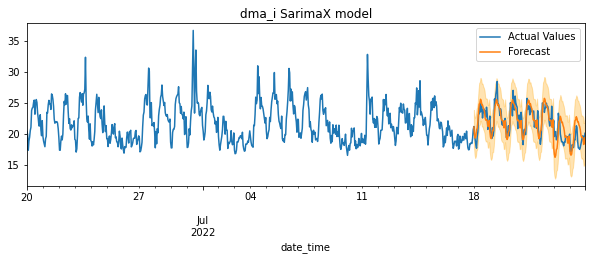

Performance indicators
dma_i SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
0.89            2.96             1.21           5.06 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.89            4.07             2.16           8.11 

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           14     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83047D+00    |proj g|=  1.78847D-01


 This problem is unconstrained.



At iterate    5    f=  1.76647D+00    |proj g|=  1.13769D-01

At iterate   10    f=  1.73833D+00    |proj g|=  1.44472D-01

At iterate   15    f=  1.73165D+00    |proj g|=  1.74316D-02

At iterate   20    f=  1.73021D+00    |proj g|=  6.40254D-03

At iterate   25    f=  1.72944D+00    |proj g|=  2.35847D-02

At iterate   30    f=  1.72794D+00    |proj g|=  2.52949D-02

At iterate   35    f=  1.72773D+00    |proj g|=  1.68693D-02

At iterate   40    f=  1.72765D+00    |proj g|=  9.66711D-03

At iterate   45    f=  1.72720D+00    |proj g|=  6.45118D-03

At iterate   50    f=  1.72699D+00    |proj g|=  6.58489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

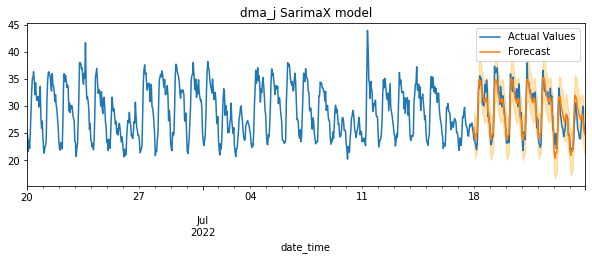

Performance indicators
dma_j SarimaX 4-Weeks
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
1.59            3.31             1.34           6.24 

Naive Forecaster
MeanAE-24h      MaxAE-24h      MeanAE-144h      Total
4.07            7.02             3.72           14.80 



In [82]:
# make empty datafram to store results
results_df = pd.DataFrame()

# make dictionary with dma position in description list
dict_dma = dict(zip(dma_list, np.arange(0,len(dma_list))))

#Parameter tuning -> start by creating an empty list to store the errors
rmse = []
#Parameter loop
for params in grid:
    # select dma for analysis
    for dma in list(inflow_data.columns):

        # copy data from dataframe in a new time series dataframe
        tseries_df = inflow_data[dma][start:end].copy()

        # demand time series
        y = tseries_df
        y_train, y_test = temporal_train_test_split(y, test_size = 168)

        # exogenous variables time series
        X = tseriesX_df
        X_train, X_test = temporal_train_test_split(X, test_size=168)

        # #print results (optional)
        # fig, ax = plt.subplots(figsize = (10,3))
        # tseries_df.plot(title = 'Naive Forecaster', ax = ax)
        # y_pred_naive.plot(ax = ax)
        # ax.legend(['Actual Values', 'Forecast'])
        # plt.show()

        # implement sarimaX model    
        # the statsmodel package applies the difference already if needed.
        
        #model
        model = pm.ARIMA(order = (params['p'],params['d'],params['q']),
                  seasonal_order = (params['P'],params['D'],params['Q'], 7),
                  X = X_train,
                  suppress_warning = True,
                  force_stationarity = False)

        model = SARIMAX(y_train, exog=X_train, order=(2,0,2), seasonal_order=(0,1,1,24)) # add seasonality of 24 hrs
        model_fit = model.fit()
        # print(model_fit.summary())

        y_pred = model_fit.get_forecast(len(y_test), exog=X_test).summary_frame(alpha=0.05)


        fig, ax = plt.subplots(figsize = (10,3))
        tseries_df.plot(title = dma[:5]+' SarimaX model', ax = ax)
        y_pred.plot(y='mean',ax = ax)
        ax.fill_between(y_pred.index, y_pred['mean_ci_lower'], y_pred['mean_ci_upper'],color='orange', alpha=0.3)
        ax.legend(['Actual Values', 'Forecast'])
        plt.show()

        print('Performance indicators')
        df = print_metrics(y_test, y_pred['mean'], dma[:5]+' SarimaX 4-Weeks',return_df=1)
        results_df = pd.concat([results_df, df])
        print_metrics(y_test, y_pred_naive, 'Naive Forecaster')

In [83]:
results_df

,MeanAE-24h,MaxAE-24h,MeanAE-144h,Total
dma_a SarimaX 4-Weeks,1.663,6.222,1.060,8.946
dma_b SarimaX 4-Weeks,1.138,4.112,0.844,6.093
dma_c SarimaX 4-Weeks,0.756,2.775,0.611,4.142
dma_d SarimaX 4-Weeks,2.350,7.166,2.255,11.771
dma_e SarimaX 4-Weeks,2.276,8.857,2.558,13.691
dma_f SarimaX 4-Weeks,0.635,2.107,0.917,3.658
dma_g SarimaX 4-Weeks,1.391,4.827,1.617,7.835
dma_h SarimaX 4-Weeks,1.632,3.859,1.579,7.070
dma_i SarimaX 4-Weeks,0.895,2.957,1.210,5.063
dma_j SarimaX 4-Weeks,1.588,3.315,1.337,6.240


In [84]:
print(f"{results_df['Total'].sum() :.2f}")

74.51


In [11]:
print(f"{results_df.drop('DMA E SarimaX 4-Weeks')['Total'].sum() :.2f}")

58.03
